# FNS-Clean Tungsten benchmark analysis 
*FNS-clean-w* is an intermediate quality neutronics experiment conducted to test the response of thick tungsten to ~14 MeV neutrons [1]. \
Neutronics code results are compared to the experiment measurements. \
Measurements include:
- Flux evaluation via activation foil reaction rate detection
- Neutron energy spectra above 2 MeV measured via spherical NE213 scintillation spectrometer
- Neutron energy spectra between 5 keV and 1 MeV measured via proton recoil gas proportional counters (PRC)
- Gamma energy spectra measured via BC537 liquid organic scintillation
- Nuclear heating measured via thermoluminescent dosimeters (TLD)

Activation foils were located at depths of 0, 7.6, 22.8, 38.0 and 50.7 cm in the shielding mockup.
All spectrometers were located at depths of 7.6, 22.8, and 38.0 cm within the shielding mockup.
TLDs were located at depths of 0, 7.6, 22.8, 38.0 cm within the shielding mockup.

the DT neutron source was located at 20 cm from the shielding mockup (-20 cm from the detector positioned at 0 cm, then).

It is worth to mention that the OpenMC simulation relies on the _weight windows_ variance reduction technique. A local weight windows file (with _wwinp_ extension) has been produced through denovo within the SCALE code [2].

Model, experimental results and MCNP results were provided by the SINBAD repository [3].

The 14 MeV neutron source characteristics of FNS was not provided. FNG neutron source characheristics has been used in substitution.

In [1]:
import openmc_fusion_benchmarks as ofb
import helpers

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')

In [3]:
# read openmc results in results_database/
openmc_fendl3_file = ofb.ResultsFromDatabase('openmc-0-14-0_fendl32b.h5', path='results_database')

### Activation foils - reaction rate analysis
The following reaction rates are included:
- $^{93}Nb(n,2n)^{92m}Nb$
- $^{27}Al(n,\alpha)^{24}Na$
- $^{115}In(n,n')^{115m}Co$
- $^{197}Au(n,\gamma)^{198}Au$
- $^{186}W(n,\gamma)^{187}W$

OpenMC evaluation of the reaction rates relies on the **_IRDFF-II_** dosimetry nuclear data library [4]. While the rest of the transport relies on the nuclear data libraries specified in the legend of the plots. A _flux multiplier_ is applied to a _track-length flux_ tally is applied on the foil _cells_.

In [4]:
# initialize reaction rate plots
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', 
                   '$^{115}$In(n,n\')$^{115m}$In', '$^{197}$Au(n,\u03B3)$^{198}$Au', 
                   '$^{186}$W(n,\u03B3)$^{187}$W']

ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

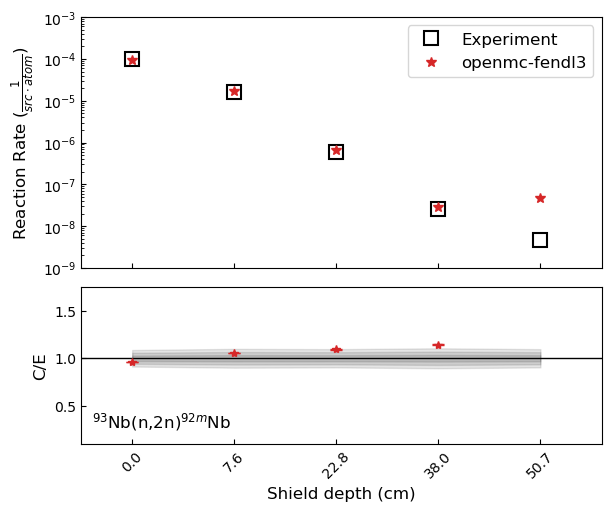

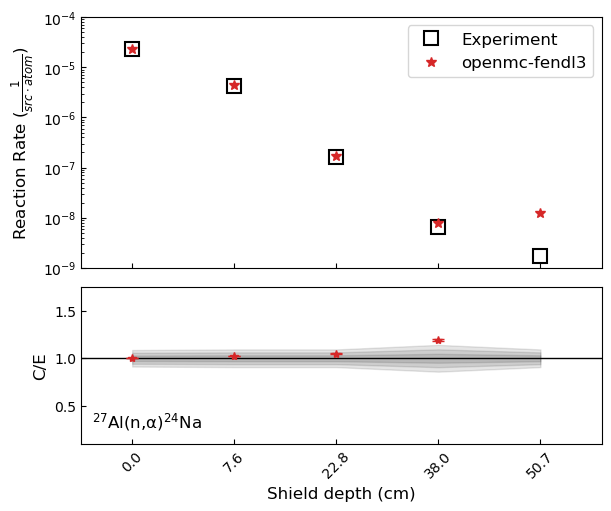

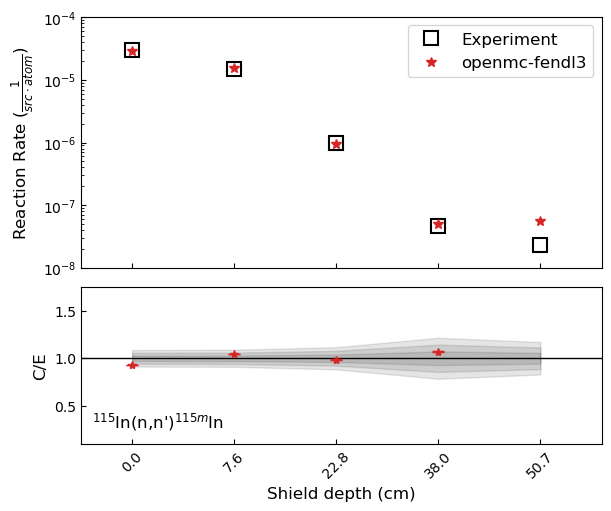

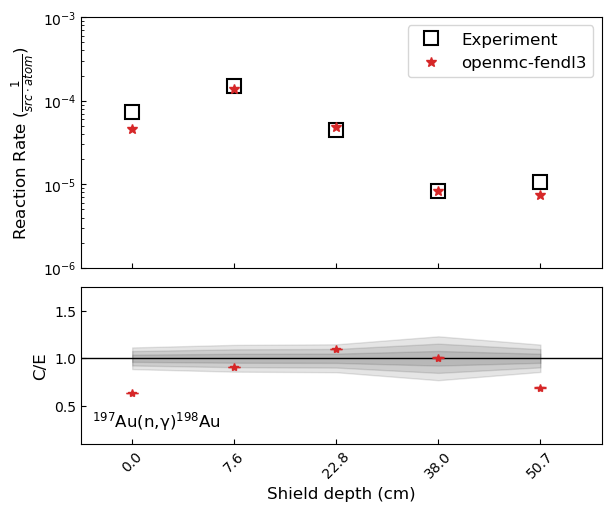

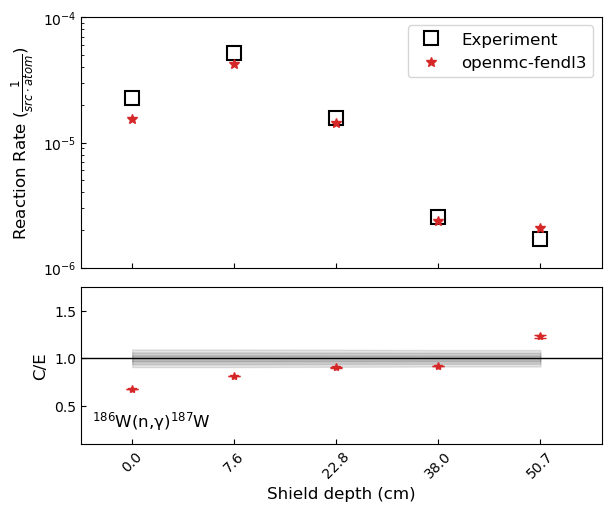

In [5]:
for i,foil in enumerate(helpers.foil_list):

    tally_name = f'rr_{foil}'

    # extract tallies
    measured = experiment_file.get_tally_dataframe(tally_name)
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(tally_name)
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    xaxis = experiment_file.get_tally_xaxis(tally_name)

    plot = ofb.PlotReactionRates(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)
    plot.add_reference_results(reference_data=measured, label='Experiment')
    plot.add_computed_results(computed_data=openmc_fendl3, marker='*', color='tab:red', label='openmc-fendl3')

### Spectrometers - neutron energy spectra

Neutron energy spectra between 5 keV and 1 MeV measured via PRC and above 2 MeV measured via NE213.

In [6]:
# initialize spectra data
ylabel = r'Neutron flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'

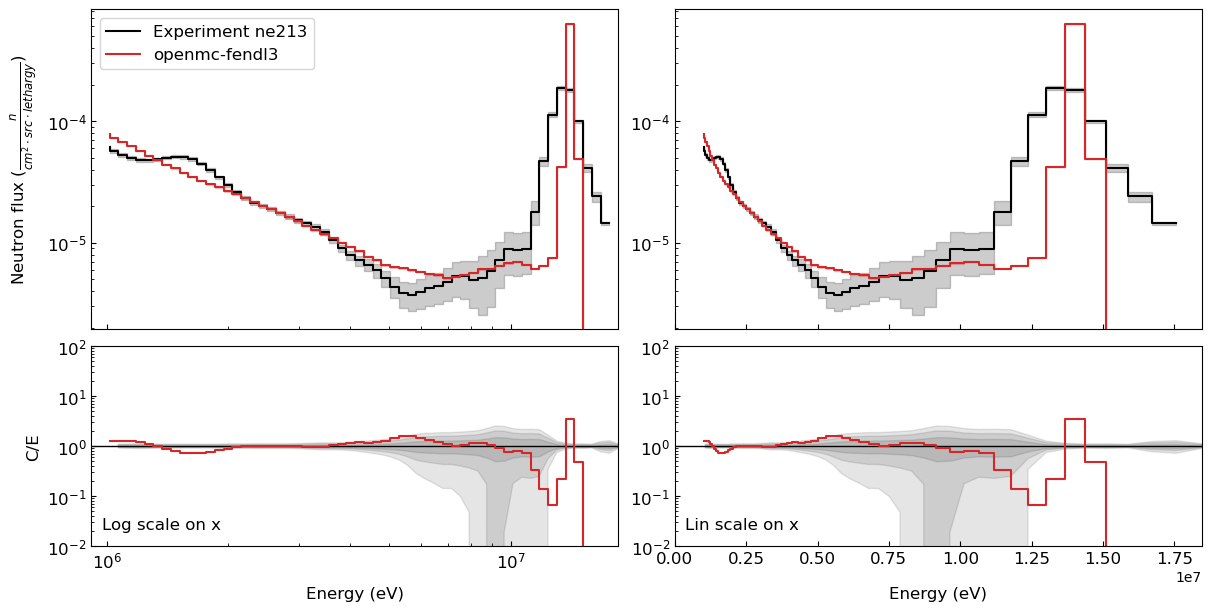

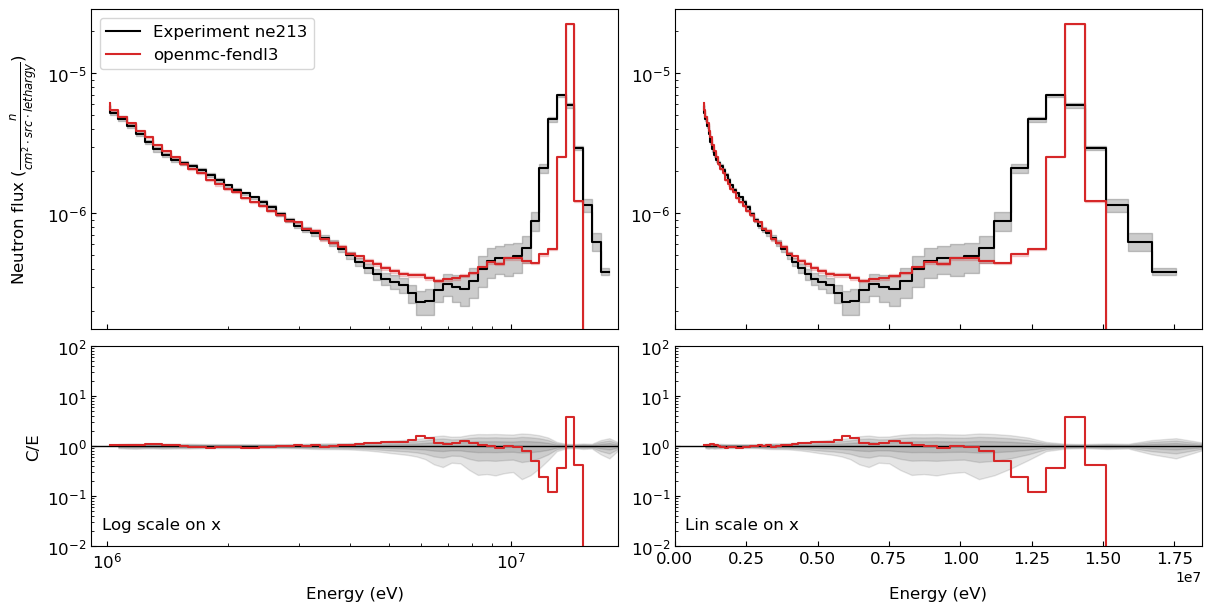

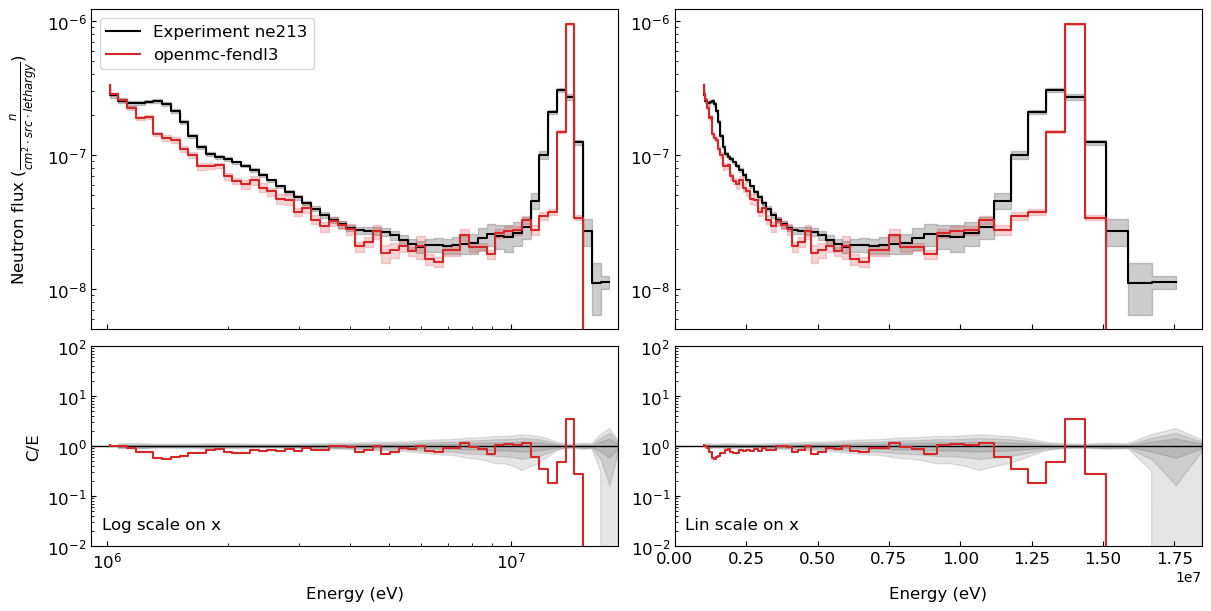

In [7]:
for i, d in enumerate(helpers.detector_list):
    # extract tallies
    ne213 = experiment_file.get_tally_dataframe(f'nspectrum_ne213_{d}')
    prc = experiment_file.get_tally_dataframe(f'nspectrum_prc_{d}')
    
    # openmc from results_database/
    openmc_fendl3_ne213 = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_ne213_{d}')
    openmc_fendl3_prc = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_prc_{d}')

    # plot
    # preprocessing
    ne213 = ofb.rescale_to_lethargy(ne213)
    openmc_fendl3_ne213 = ofb.rescale_to_lethargy(openmc_fendl3_ne213)

    plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=f'detector {i}')
    plot.add_reference_results(reference_data=ne213, label='Experiment ne213')
    plot.add_computed_results(computed_data=openmc_fendl3_ne213, color='tab:red', alpha=1, label='openmc-fendl3')

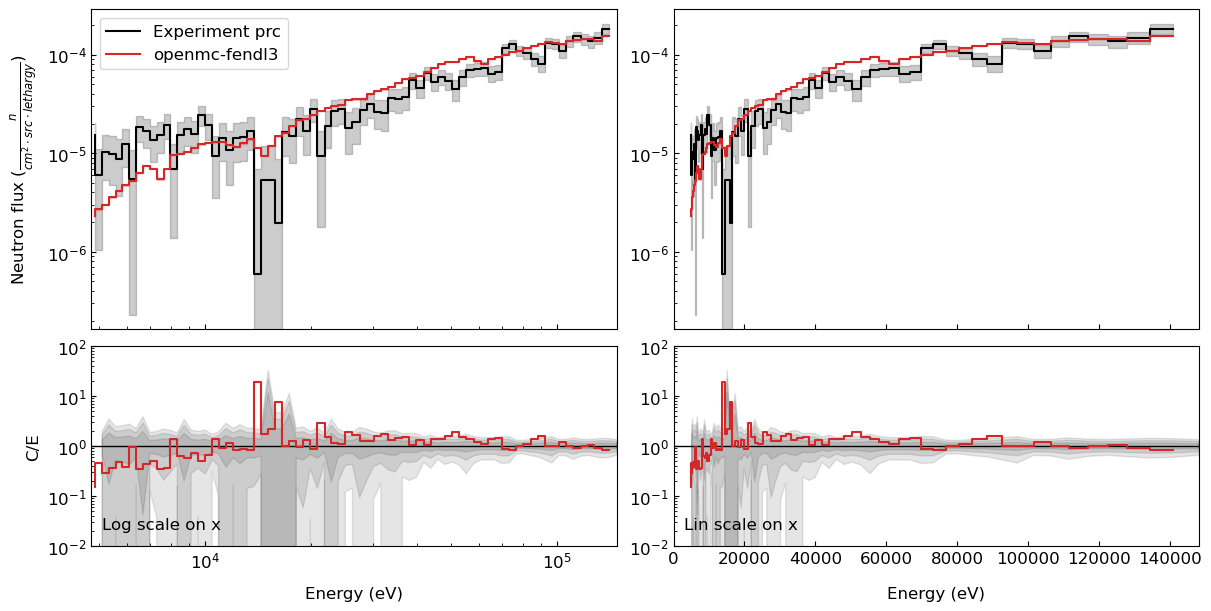

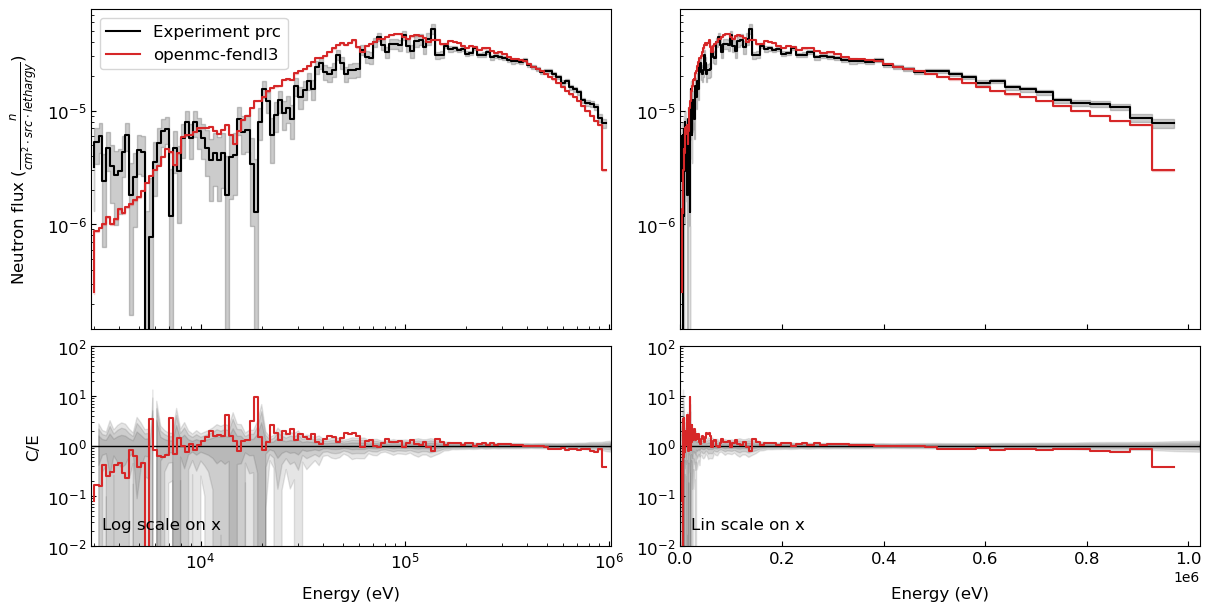

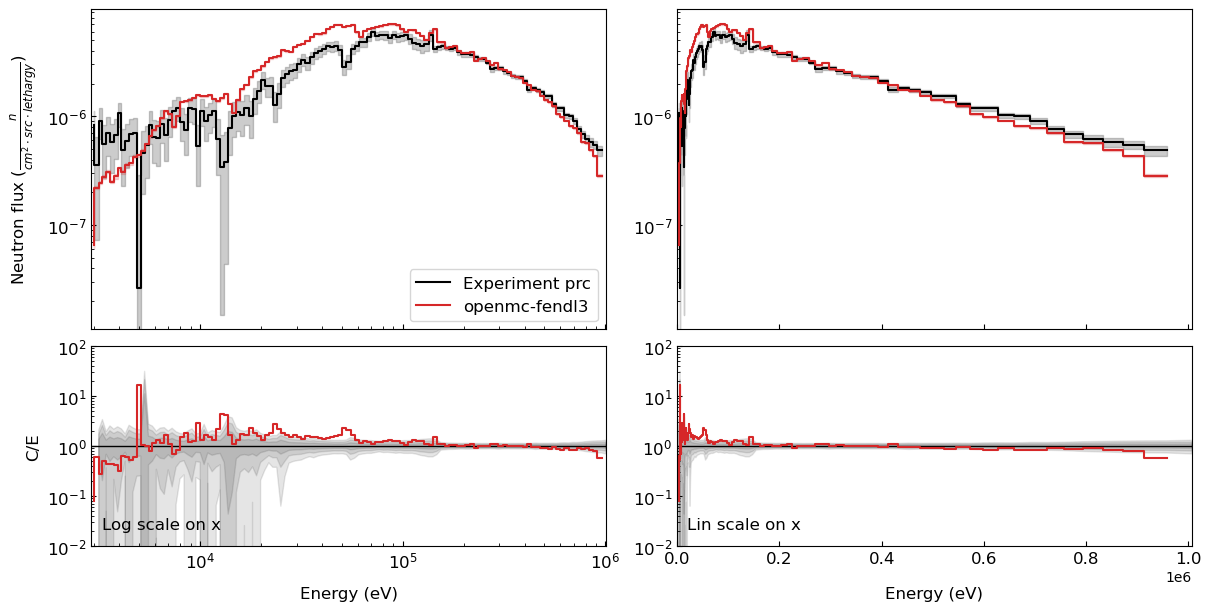

In [8]:
for i, d in enumerate(helpers.detector_list):
    # extract tallies
    prc = experiment_file.get_tally_dataframe(f'nspectrum_prc_{d}')
    
    # openmc from results_database/
    openmc_fendl3_prc = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_prc_{d}')

    # plot
    # preprocessing
    prc = ofb.rescale_to_lethargy(prc)
    openmc_fendl3_prc = ofb.rescale_to_lethargy(ofb.rebin_spectrum(openmc_fendl3_prc, prc['energy low [eV]'], prc['energy high [eV]']))

    plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=f'detector {i}')
    plot.add_reference_results(reference_data=prc, label='Experiment prc')
    plot.add_computed_results(computed_data=openmc_fendl3_prc, color='tab:red', alpha=1, label='openmc-fendl3')

### Spectrometers - gamma energy spectra

Gamma energy spectra measured via BC537.

In [9]:
# initialize spectra data
detector_position = ['76', '228', '380']
ylabel = r'Gamma flux $(\frac{p}{cm^2 \cdot src \cdot lethargy})$'

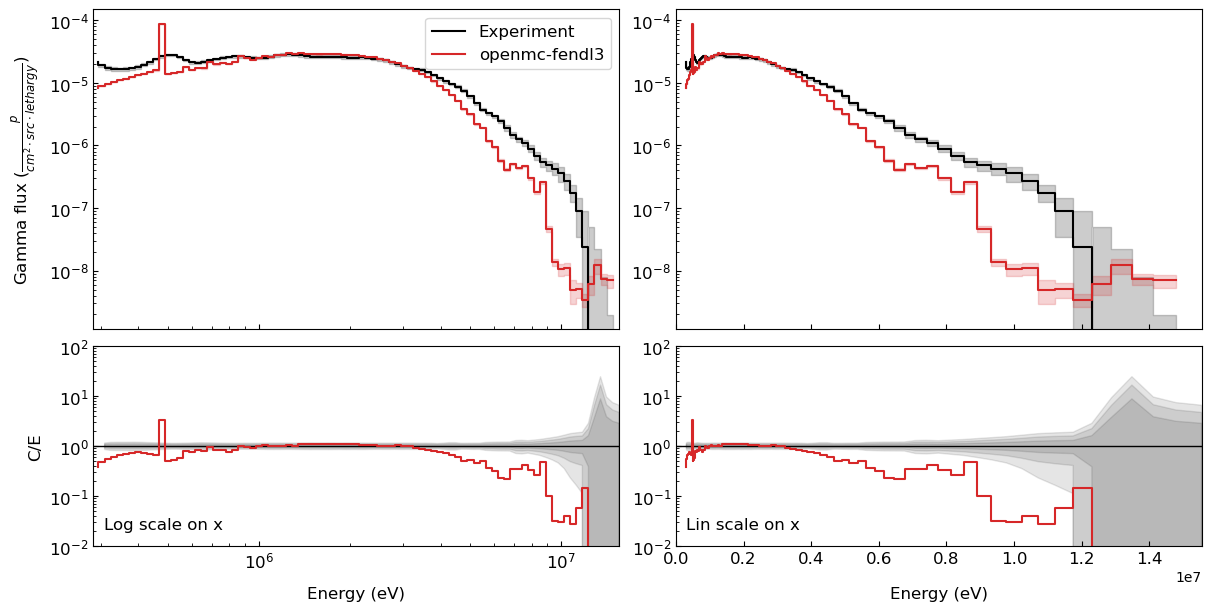

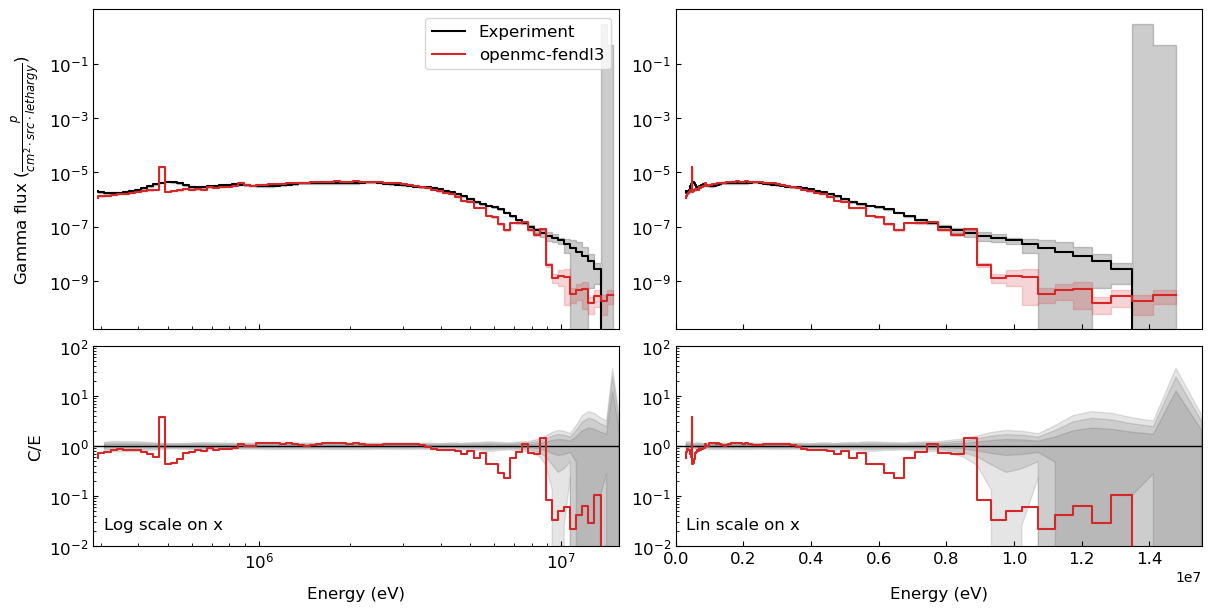

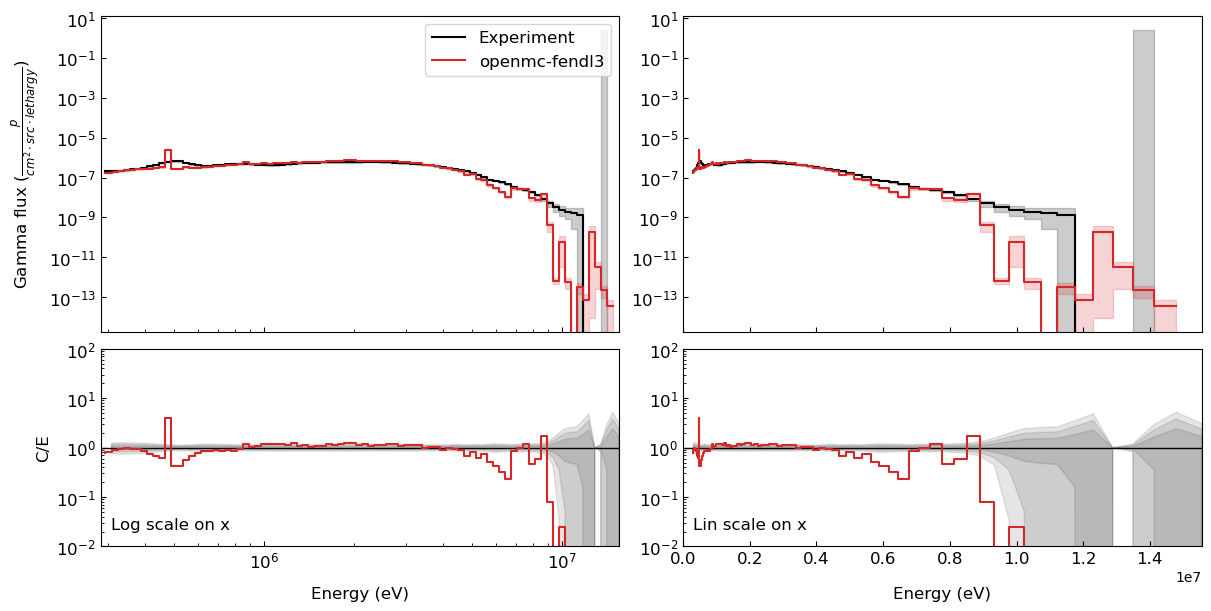

In [10]:
for i, d in enumerate(helpers.detector_list):
    # extract tallies
    bc537 = experiment_file.get_tally_dataframe(f'gspectrum_bc537_{d}')
    
    # # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'gspectrum_bc537_{d}')

    # plot
    # preprocessing
    bc537 = ofb.rescale_to_lethargy(bc537)
    openmc_fendl3 = ofb.rescale_to_lethargy(openmc_fendl3)
    
    # generate figure
    plot = ofb.PlotEnergySpectra(xaxis=xaxis, ylabel=ylabel, dtype_label=f'detector {i}')
    plot.add_reference_results(reference_data=bc537, label='Experiment')
    plot.add_computed_results(computed_data=openmc_fendl3, color='tab:red', alpha=1, label='openmc-fendl3')

### Thermoluminescent detectors - nuclear heating analysis
Nuclear heating has been measured via thermoluminescent detectors which measured the dose deposited in _Gy/src_.

For this case, the OpenMC model featuring a _heating tally_ required _photon transport_ activated alongside _neutron transport_. The contributions of _neutrons_, _photons_, _electrons_ and _positrons_ have been evaluated.

In the fng-str benchmark calibration coefficients for the heating tallies were provided [3]. And the deposited dose (Q) was computed as follows:

$$Q = Q_n\cdot c_n\cdot c_e + \sum(Q_i)\cdot c_p  \tag{1}$$

where $Q_n$ is the neutron contribution and $\sum(Q_i)$ is the contribution of the other particles to the nuclear heating \
$C_n$ is the ratio of the TLD/material absorbed neutron dose \
$C_p$ is the ratio of the TLD/material absorbed photon dose \
$C_e$ is the TLD neutron dose efficiency with respect to the photon dose efficiency, taken from published data and weighted over the neutron spectra

The coefficients have not been provided for fns-clean-w and, unlike in the fng-w case, we did not adjust the order of magnitude of $c_n$. We then applied equation (1) with all the coefficients equal to 1. However, it is essential to explore these discrepancies in the approach required for modeling TLD results.

This process is done in the `helpers` and it is automated in the `run_and_store` script.

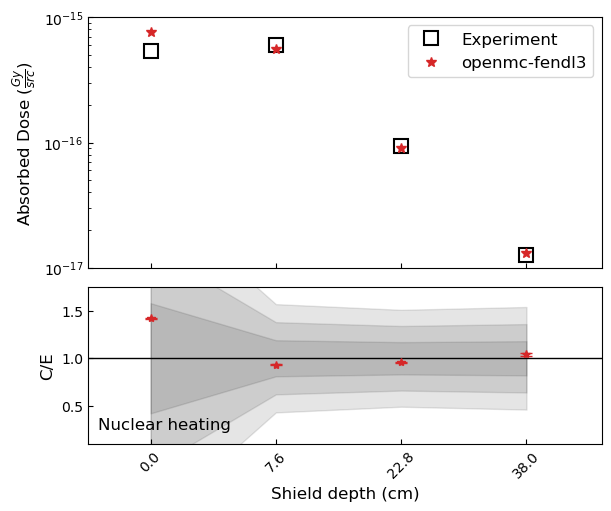

In [11]:
ylabel = r'Absorbed Dose $(\frac{Gy}{src})$'
# extract tallies
measured = experiment_file.get_tally_dataframe('nuclear_heating')

# openmc from results_database
openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe('nuclear_heating')

# plot
# preprocessing
dtype_label = 'Nuclear heating'
xaxis = experiment_file.get_tally_xaxis('nuclear_heating')

plot = ofb.PlotNuclearHeating(xaxis=xaxis, ylabel=ylabel, dtype_label=dtype_label)
plot.add_reference_results(reference_data=measured, label='Experiment')
plot.add_computed_results(computed_data=openmc_fendl3, marker='*', color='tab:red', label='openmc-fendl3')

## References
[1] Maekawa, F., et al. "Data collection of fusion neutronics benchmark experiment conducted at FNS/JAERI". No. JAERI-DATA/CODE--98-021. Japan Atomic Energy Research Inst., 1998. https://inis.iaea.org/search/search.aspx?orig_q=RN:29054903 \
[2] Evans, Thomas M., et al. "Denovo: A new three-dimensional parallel discrete ordinates code in SCALE." Nuclear technology 171.2 (2010): 171-200. https://doi.org/10.13182/NT171-171 \
[3] Kodeli, I. A., et al. "SINBAD–Radiation shielding benchmark experiments." Annals of Nuclear Energy 159 (2021): 108254. https://doi.org/10.1016/j.anucene.2021.108254 \
[4] Trkov, A., et al. "IRDFF-II: a new neutron metrology library." Nuclear Data Sheets 163 (2020): 1-108. https://doi.org/10.1016/j.nds.2019.12.001